<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/real_estate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
!pip install --upgrade git+https://github.com/noahgolmant/pytorch-hessian-eigenthings.git@master#egg=hessian-eigenthings

  Cloning https://github.com/noahgolmant/pytorch-hessian-eigenthings.git (to revision master) to /tmp/pip-install-rany0q_h/hessian-eigenthings_3a8ed45907e8497e92333fb2eae70471
  Running command git clone -q https://github.com/noahgolmant/pytorch-hessian-eigenthings.git /tmp/pip-install-rany0q_h/hessian-eigenthings_3a8ed45907e8497e92333fb2eae70471
  Created wheel for hessian-eigenthings: filename=hessian_eigenthings-0.0.2-py3-none-any.whl size=9671 sha256=7e73213bf98b1c277181c4983ff9740e4f7f62b98c2fdea274ac61180bc1e192
  Stored in directory: /tmp/pip-ephem-wheel-cache-axh3e4rm/wheels/7d/a8/45/394ac423a7268a364a0a0453ca63748540b398a050e674af66
Successfully built hessian-eigenthings


In [ ]:
from hessian_eigenthings import compute_hessian_eigenthings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from matplotlib import pyplot as plt
from collections import OrderedDict

In [ ]:
PLOTTING_PARAM = 10

In [ ]:
data_url = "https://raw.githubusercontent.com/ItayShalit/Intro-to-Deep-Learning/main/real-estate-data.csv"


In [ ]:
target = 'Y house price of unit area'
df = pd.read_csv(data_url).drop('No', axis = 1)
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.drop(target, axis = 1).to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'Y house price of unit area'])
df = pd.concat([df_scaled, df], axis = 1)

train, test = train_test_split(df, test_size = 0.25)

In [ ]:

batch_size = len(train) #Training full batch

train_target = torch.tensor(train[target].values.astype(np.float32))
train = torch.tensor(train.drop(target, axis = 1).values.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

test_target = torch.tensor(test[target].values.astype(np.float32))
test = torch.tensor(test.drop(target, axis = 1).values.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
# labels = ['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']

def calculate_gradient_l2_norm(model):
    mean_l2_norm = 0
    grad_num = 0
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        grad_num += len(p)
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        mean_l2_norm += (p.grad.data.norm(2).item())*(len(p)/grad_num)
    return mean_l2_norm

def train_loop(dataloader, model, loss_fn, optimizer, device, print_progress = False):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress&(batch % 100 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device, return_results = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    if return_results:
        return test_loss, correct

def train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device):
    loss_values, loss_grad_l2_norm, min_eigenvalues_of_hessian, max_eigenvalues_of_hessian  = [], [], [], []
    for t in range(epochs):
        train_loop(trainloader, model, loss_fn, optimizer, device)
        test_loss, test_accuracy = test_loop(testloader, model, loss_fn, device, True)
        loss_values.append(test_loss)
        loss_grad_l2_norm.append(calculate_gradient_l2_norm(model))
        eigenvals, eigenvecs = compute_hessian_eigenthings(model, trainloader,
                                                   loss_fn, 12)
        if t%PLOTTING_PARAM == 0:
          min_eigenvalues_of_hessian.append(min(eigenvals))
          max_eigenvalues_of_hessian.append(max(eigenvals))
    return loss_values, loss_grad_l2_norm, min_eigenvalues_of_hessian, max_eigenvalues_of_hessian
  
def plot_results(results):
  figure = plt.figure(figsize=(18, 6))
  ax1 = figure.add_subplot(1,2,1)
  ax2 = figure.add_subplot(1,2,2)
  ax1 = figure.get_axes()[0]
  ax2 = figure.get_axes()[1]
  full_x_axis = [i for i in range(epochs)]
  five_interval_x_axis = [i for i in range(epochs) if i%PLOTTING_PARAM == 0]
  ax1.plot(full_x_axis, results[0], label='Objective Value')
  ax1.plot(full_x_axis, results[1], label='L2 Norm of Loss Gradients')
  ax2.plot(five_interval_x_axis, results[2], label='Min Eigenvalue of Hessian')
  ax2.plot(five_interval_x_axis, results[3], label='Max Eigenvalue of Hessian')
  ax1.legend()
  ax2.legend()
  figure.show()

def train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device):
    results = train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)
    plot_results(results)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(12, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits


def NNClassGeneratorByDepth(depth):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          sequence = OrderedDict()
          sequence['lin1'] = nn.Linear(12, 128)
          for i in range(depth-1):
            sequence[f'lin{i+2}'] = nn.Linear(128, 128)
          sequence[f'lin{depth + 1}'] = nn.Linear(128, 1)
          self.linear_relu_stack = nn.Sequential(sequence)

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

Using cuda device
FFNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (lin1): Linear(in_features=12, out_features=128, bias=True)
    (lin2): Linear(in_features=128, out_features=128, bias=True)
    (lin3): Linear(in_features=128, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([310])) that is different to the input size (torch.Size([310, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 [=============================================================>...]  Step: 21ms | Tot: 430ms | power iter error: 0.0034 20/20 
 [=============================================================>...]  Step: 20ms | Tot: 481ms | power iter error: 0.0008 20/20 
 [=============================================================>...]  Step: 35ms | Tot: 444ms | power iter error: 0.0001 20/20 
 [=============================================================>...]  Step: 50ms | Tot: 915ms | power iter error: nan 20/20 
 [=============================================================>...]  Step: 39ms | Tot: 948ms | power iter error: nan 20/20 
 [=============================================================>...]  Step: 45ms | Tot: 806ms | power iter error: na

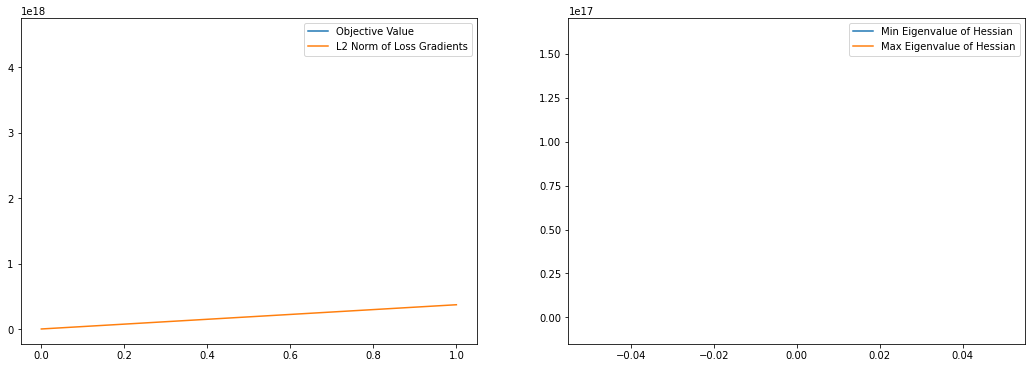

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
momentum_param = 0.95
epochs = 4

# for depth in [2,3,4]:
for depth in [2]:
  NNClass = NNClassGeneratorByDepth(depth)
  model = NNClass().to(device)
  print(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_param)
  train_and_plot_results(train_loader, test_loader, model, loss_fn, optimizer, epochs, device)